In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Input,Dense,LSTM,MultiHeadAttention,LayerNormalization,GlobalAveragePooling1D
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from time import perf_counter
import os

2025-04-18 11:51:35.414189: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-18 11:51:35.414238: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-18 11:51:35.414256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-18 11:51:35.419803: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## you could delete this line here (os one)
- i needed it cause im using wsl for tensorflow, but in normal windows, its possible to remove it 

In [2]:
import os
os.chdir('/tf-acno-projects/Project-Data-Mining')

In [3]:
def X_y_forecasting_splits(Datafile,time_steps):
    X,y = list(),list()
    for start in range(len(Datafile)):
        end = start+time_steps 
        if end>len(Datafile)-1:
            break
        X.append(Datafile.iloc[start:end].values)
        y.append(Datafile.iloc[end]["CO2 Emission"])
    return np.array(X),np.array(y)

In [4]:
def months_converter(DataFile):
    unique_months = DataFile['Month'].unique()
    months_dict = {
        month:idx+1 for idx,month in enumerate(unique_months)
    }
    DataFile['Month'] = DataFile['Month'].map(months_dict)

In [5]:
def lstm_architecture(input_shape,lr,d_model):
    input_layer = Input(shape=input_shape)
    hidden_layer = LSTM(d_model, return_sequences=True)(input_layer)
    hidden_layer = LSTM(d_model//2, return_sequences=True)(hidden_layer)
    hidden_layer = LSTM(d_model//2, return_sequences=True)(hidden_layer)
    hidden_layer = LSTM(d_model//4)(hidden_layer)
    hidden_layer = Dense(d_model//8,activation='relu')(hidden_layer)
    output_layer = Dense(1,activation='linear')(hidden_layer)

    lstm_model = Model(input_layer,output_layer)
    lstm_model.compile(optimizer=Adam(learning_rate=lr),loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])
    return lstm_model

In [6]:
def positional_encoding(sequence_length,d_model,n=10000):
    """
    - d_model: the dimension of our input ( output of the embedding space )
    - sequence_length: the length of our sequence for example we have 3 features then its 3
    """
    PosEnc = np.zeros((sequence_length,d_model))
    indices = np.arange(int(d_model/2))
    positions = np.arange((sequence_length))
    
    for position in positions:
        for index in indices:
            denomenator = np.power(n,2*index/d_model)
            PosEnc[position,2*index] = np.sin(position/denomenator)
            PosEnc[position,2*index+1] = np.cos(position/denomenator)

    pos_enc_tensor = tf.constant(PosEnc, dtype=tf.float32)
    pos_enc_tensor = tf.reshape(pos_enc_tensor, (1, sequence_length, d_model))
    return pos_enc_tensor

In [7]:
def transformer_embedding_positioning(sequence_length,d_model,input_layer):
    """
    - We use **the embedding** which is a way to convert raw input into a high-dimensional vector (d_model in this case).
        so our embedding vector shape is **(batch_size,time,features_embedding)**
    - **Positional encoding** is added to this embedding vector so the model knows about the position of each token or feature.
    """
    x_embedded = Dense(d_model)(input_layer)
    pos_enc = positional_encoding(sequence_length,d_model)
    return x_embedded + pos_enc

In [8]:
def transformer_encoder(x,d_model,num_heads,key_dim):
    attention_layer = MultiHeadAttention(num_heads=num_heads,key_dim=key_dim)(x,x)
    add_norm1 = LayerNormalization(epsilon=1e-6)(x+attention_layer)
    
    feed_forward_input = Dense(d_model,activation='relu')(add_norm1)
    feed_forward_output = Dense(d_model)(feed_forward_input)
    add_norm2 = LayerNormalization(epsilon=1e-6)(add_norm1+feed_forward_output)
    
    return add_norm2

<div align="center">
  <img src="static/encoder_transformer.png" width="300" height="500"/>
</div>

- The image above taken from the Transformer Encoder Architecture set by <a href='https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf' >'Attention is all you need'</a> Paper
- We didnt used the second part (the decoder) cause we want to predict for each input a single output and not as the decoder does by giving a whole batch of outputs 

In [9]:
def transformer_architecture(input_shape,lr,sequence_length,d_model,num_heads,key_dim):   
    input_layer = Input(shape=input_shape)
    x_positioned_embedded = transformer_embedding_positioning(sequence_length,d_model,input_layer) 
    x1 = transformer_encoder(x_positioned_embedded,d_model,num_heads,key_dim)
    x2 = transformer_encoder(x1,d_model,num_heads,key_dim)
    x3 = transformer_encoder(x2,d_model,num_heads,key_dim)
    x_last = GlobalAveragePooling1D()(x3)
    output_layer = Dense(1)(x_last)
    
    transformer = Model(input_layer,output_layer)
    transformer.compile(optimizer=Adam(learning_rate=lr),loss=MeanSquaredError(),metrics=[MeanAbsoluteError()])
    return transformer

In [10]:
def models_perf_metrics_saving(perf_df_path,metrics_df_path,new_perf_df,new_metrics_df):
    if os.path.exists(os.path.join(os.getcwd(), perf_df_path)):   
        performance_df_old = pd.read_csv(perf_df_path)
        performance_df_old = pd.concat([performance_df_old,new_perf_df],ignore_index=True)
        metrics_df_old = pd.read_csv(metrics_df_path)
        metrics_df_old = pd.concat([metrics_df_old,new_metrics_df],ignore_index=True)
        
        performance_df_old.to_csv(perf_df_path,index=False)
        metrics_df_old.to_csv(metrics_df_path,index=False)
        print(f'Concatenation to the old {perf_df_path}, {metrics_df_path} csv files')
    else:
        new_perf_df.to_csv(perf_df_path)
        new_metrics_df.to_csv(metrics_df_path)
        print(f'Creation of new {perf_df_path}, {metrics_df_path} csv files')

In [11]:
DataFile = pd.read_csv("Emission.csv")
DataFile.head()

,Year-Month,CO2 Emission
0,1973-Jan,106.363
1,1973-Feb,101.760
2,1973-Mar,110.553
3,1973-Apr,104.734
4,1973-May,114.897


In [12]:
print(DataFile.isnull().sum())
print(DataFile.duplicated().sum())

Alright, there are no null values and no duplicates but there is something wrong with the "Year-Month" column, it's better to split it into two and convert them to numerical values

In [13]:
DataFile[['Year', 'Month']] = DataFile['Year-Month'].str.split('-', expand=True)

DataFile.drop(columns=['Year-Month'], inplace=True)

In [14]:
months_converter(DataFile)

for col in DataFile.columns:
    DataFile[col] = pd.to_numeric(DataFile[col],errors='coerce')
print(DataFile)
print(DataFile.dtypes)

In [15]:
print(f'Dataset Min : {DataFile["CO2 Emission"].min()}')
print(f'Dataset Max : {DataFile["CO2 Emission"].max()}')
print(f'Dataset Mean : {DataFile["CO2 Emission"].mean()}')
print(f'Dataset STD : {DataFile["CO2 Emission"].std()}')
DataFile.to_csv("New Emission.csv", index=False)

this is a note that we should scale the data later on for our models so we could detect overfitting or underfitting

## Visual Analysis

In [16]:
plt.figure(figsize=(8, 5))
plt.plot(DataFile["Year"], DataFile["CO2 Emission"], marker="o", linestyle="-", color="b")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission Over the Years")
plt.grid(True)

# Show the plot
plt.show()

In [17]:
plt.figure(figsize=(8, 5))
sns.barplot(x=DataFile["Month"], y=DataFile["CO2 Emission"], palette="coolwarm")

# Labels and Title
plt.xlabel("Month")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Month")

# Show the plot
plt.show()

In [18]:
plt.figure(figsize=(12, 5))
sns.barplot(x=DataFile["Year"], y=DataFile["CO2 Emission"], palette="coolwarm")

# Labels and Title
plt.xlabel("Year")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Year")

plt.xticks(rotation=45, ha="right")

# Show the plot
plt.show()

It's kind of a complex figure so we will group the years into ranges

In [19]:
min_year = DataFile["Year"].min()
max_year = DataFile["Year"].max()

print(min_year)
print(max_year)

In [24]:
bins = [1970, 1975, 1980, 1985, 1990, 1995, 2000, 2005, 2010, 2015]

labels = ["1971-1975", "1976-1980", "1981-1985", "1986-1990", "1991-1995", "1996-2000", "2001-2005", "2006-2010", "2011-2015"]

DataFile["Year Range"] = pd.cut(DataFile["Year"], bins=bins, labels=labels, right=True)
print(DataFile[["Year", "Year Range"]].head())

In [25]:
plt.figure(figsize=(12, 5))  # Increase width
sns.barplot(x=DataFile["Year Range"], y=DataFile["CO2 Emission"], palette="coolwarm")

plt.xlabel("Year Range")
plt.ylabel("CO2 Emission (ppm)")
plt.title("CO2 Emission by Year Range")

plt.xticks(rotation=45, ha="right")  # Rotate labels for better spacing

plt.show()


In [22]:
DataFile.drop(columns=['Year Range'], inplace=True)

## Training Process !

In [12]:
DataFile = pd.read_csv("New Emission.csv") # reading our cleaned dataset

## ARIMA AND SARIMA

In [13]:
# Train-test split
split_ratio = 0.8
train_size = int(len(DataFile) * split_ratio)
train, test = DataFile.iloc[:train_size], DataFile.iloc[train_size:]

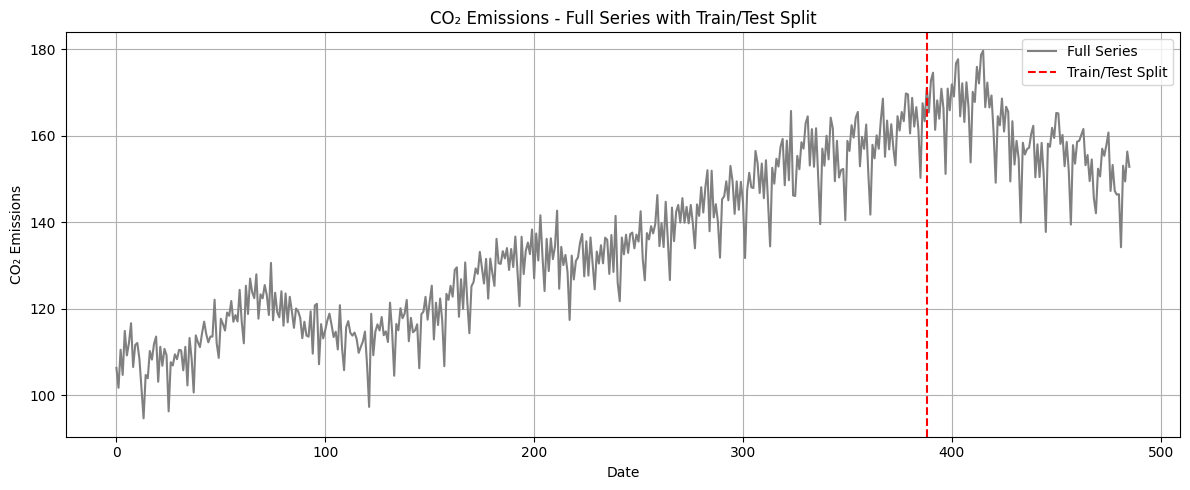

In [14]:
#Full time series with train/test split
plt.figure(figsize=(12, 5))
plt.plot(DataFile.index, DataFile['CO2 Emission'], label='Full Series', color='gray')
plt.axvline(test.index[0], color='red', linestyle='--', label='Train/Test Split')
plt.title('CO₂ Emissions - Full Series with Train/Test Split')
plt.xlabel('Date')
plt.ylabel('CO₂ Emissions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
# Helper function to evaluate for classic machine learning models in our case (Arima/Sarima)
def evaluate_forecast(y_true, y_pred):
    y_mean = np.mean(y_true)
    sce = np.sum((y_pred - y_mean) ** 2)
    sst = np.sum((y_true - y_mean) ** 2)
    
    return {
        "RMSE": np.sqrt(np.mean(np.sum((y_pred-y_true)**2))),
        "MAE": np.mean(np.abs(y_pred - y_true)),
        "R²":  sce / sst # r2 = SCE / SST
    }
  
# Store results
results = {}

In [16]:
print("Training ARIMA...")
best_rmse = float('inf')
best_order = None
best_model = None
# Grid search ARIMA(p,d,q)

for p in range(0, 4):
    for d in range(0, 2):
        for q in range(0, 4):
            try:
                start = perf_counter()
                model = ARIMA(train['CO2 Emission'], order=(p,d,q))
                model_fit = model.fit()
                forecast = model_fit.forecast(steps=len(test))
                elapsed = perf_counter() - start
                scores = evaluate_forecast(test['CO2 Emission'], forecast)
                if scores['RMSE'] < best_rmse:
                    best_rmse = scores['RMSE']
                    best_order = (p,d,q)
                    best_model = model_fit
                    results['ARIMA'] = {
                        "Order": best_order,
                        "Metrics": scores,
                        "Training Time (s)": elapsed
                    }
            except:
                continue

print("Best ARIMA order:", best_order)
print("ARIMA Results:", results['ARIMA'])

Training ARIMA...


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.11/dist-packages/st

Best ARIMA order: (3, 0, 2)
ARIMA Results: {'Order': (3, 0, 2), 'Metrics': {'RMSE': 83.10799871139275, 'MAE': 6.541859144474969, 'R²': 0.042641974411375426}, 'Training Time (s)': 0.1240856119993623}


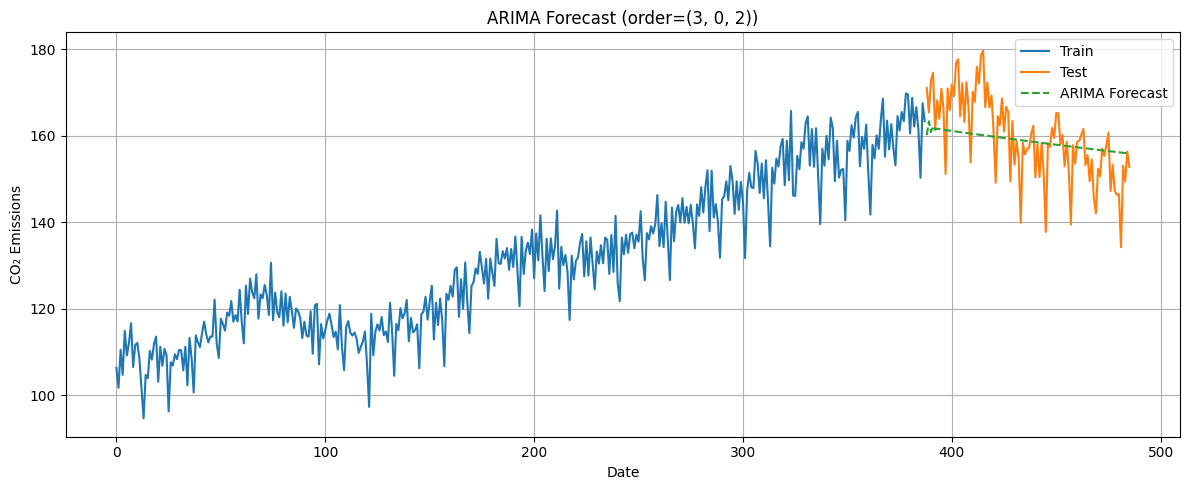

In [17]:
# Plot 2: ARIMA Forecast vs Actual
if 'ARIMA' in results:
    forecast_arima = best_model.forecast(steps=len(test))
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train['CO2 Emission'], label='Train')
    plt.plot(test.index, test['CO2 Emission'], label='Test')
    plt.plot(test.index, forecast_arima, label='ARIMA Forecast', linestyle='--')
    plt.title(f'ARIMA Forecast (order={results["ARIMA"]["Order"]})')
    plt.xlabel('Date')
    plt.ylabel('CO₂ Emissions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
print("\nTraining SARIMA...")
best_rmse = float('inf')
best_order = None
best_seasonal = None
best_model = None

# Grid search SARIMA(p,d,q)(P,D,Q,s)

for p in range(0, 3):
    for d in range(0, 2):
        for q in range(0, 3):
            for P in range(0, 2):
                for D in range(0, 2):
                    for Q in range(0, 2):
                        try:
                            start = perf_counter()
                            model = SARIMAX(train['CO2 Emission'], order=(p,d,q),
                                            seasonal_order=(P,D,Q,12),
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
                            model_fit = model.fit(disp=False)
                            forecast = model_fit.forecast(steps=len(test))
                            elapsed = perf_counter() - start
                            scores = evaluate_forecast(test['CO2 Emission'], forecast)
                            if scores['RMSE'] < best_rmse:
                                best_rmse = scores['RMSE']
                                best_order = (p,d,q)
                                best_seasonal = (P,D,Q,12)
                                best_model = model_fit
                                results['SARIMA'] = {
                                    "Order": best_order,
                                    "Seasonal Order": best_seasonal,
                                    "Metrics": scores,
                                    "Training Time (s)": elapsed
                                }
                        except:
                            continue

print("Best SARIMA order:", best_order, "seasonal:", best_seasonal)
print("SARIMA Results:", results['SARIMA'])


Training SARIMA...


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Best SARIMA order: (2, 0, 0) seasonal: (1, 1, 1, 12)
SARIMA Results: {'Order': (2, 0, 0), 'Seasonal Order': (1, 1, 1, 12), 'Metrics': {'RMSE': 66.92514764595659, 'MAE': 5.880657418784956, 'R²': 0.39745657176106547}, 'Training Time (s)': 0.2990573810002388}


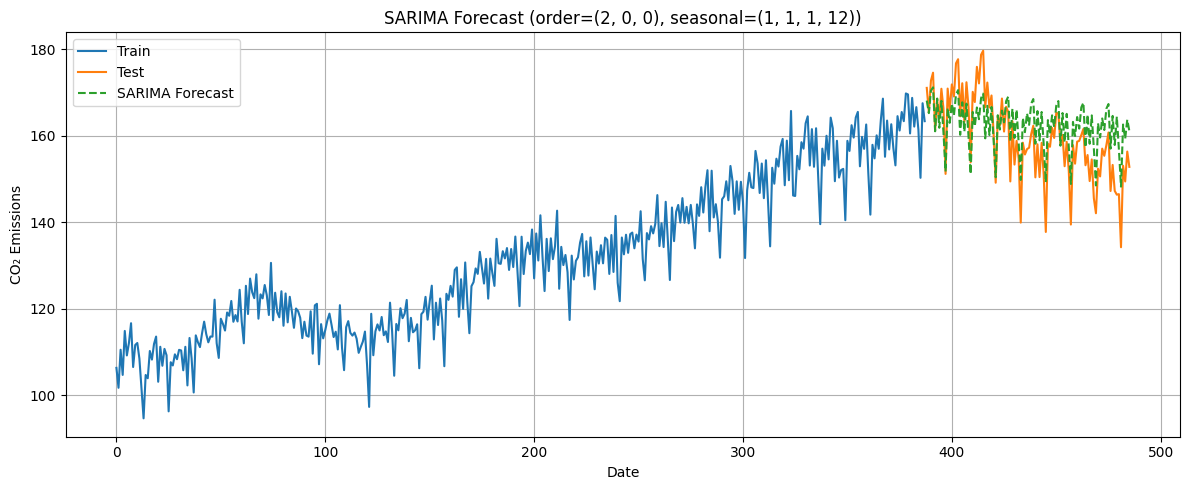

In [19]:
# Plot 3: SARIMA Forecast vs Actual
if 'SARIMA' in results:
    forecast_sarima = best_model.forecast(steps=len(test))
    plt.figure(figsize=(12, 5))
    plt.plot(train.index, train['CO2 Emission'], label='Train')
    plt.plot(test.index, test['CO2 Emission'], label='Test')
    plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', linestyle='--')
    plt.title(f'SARIMA Forecast (order={results["SARIMA"]["Order"]}, seasonal={results["SARIMA"]["Seasonal Order"]})')
    plt.xlabel('Date')
    plt.ylabel('CO₂ Emissions')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## LSTM AND TRANSFORMERS


In [159]:
TIME_STEP = 1
INPUT_SHAPE = (TIME_STEP,3) # (time_step, features)
LR = 0.0001
EPOCHS = 100
N_SPLITS = 3
D_MODEL = 512
CALLBACK = [
    ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=10,
    min_delta=0.0001,
    min_lr=1e-7,
    ),]
#EarlyStopping(monitor="val_loss",patience=20,min_delta=0.0001,)

In [160]:
X,y = X_y_forecasting_splits(DataFile,TIME_STEP)
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y.reshape(-1,1)).flatten()

### LSTM

In [122]:
folds_histories = []
folds_metrics = []
lstm_perf_filename = 'lstm_performance.csv'
lstm_metrics_filename = 'lstm_metrics.csv'

time_series_split_folds = TimeSeriesSplit(n_splits=N_SPLITS)
for fold ,(training_idx, validation_idx) in enumerate(time_series_split_folds.split(X,y)):
    lstm_model = lstm_architecture(INPUT_SHAPE,LR,D_MODEL)

    X_train_cv = tf.convert_to_tensor(X[training_idx], dtype=tf.float32)
    X_val_cv = tf.convert_to_tensor(X[validation_idx], dtype=tf.float32)
    y_train_cv = tf.convert_to_tensor(y_scaled[training_idx], dtype=tf.float32)
    y_val_cv = tf.convert_to_tensor(y_scaled[validation_idx], dtype=tf.float32)
    
    train_start = perf_counter()
    history = lstm_model.fit(X_train_cv,y_train_cv,epochs=EPOCHS,validation_data=(X_val_cv,y_val_cv),callbacks=CALLBACK,verbose=0)
    train_end = perf_counter()
    
    val_loss, val_mae = lstm_model.evaluate(X_val_cv, y_val_cv,verbose=0)
    
    y_val_preds = lstm_model.predict(X_val_cv)
    # Reshaping to remove the extra dim
    y_val_preds_reshaped = y_val_preds.reshape(-1, 1) # from (dim1,1) to (dim1,)
    # to get the original co2 values not between 0-1 we apply inverse_transform
    y_val_preds_original = scaler.inverse_transform(y_val_preds_reshaped).flatten()

    # Reshaping to remove the extra dim
    y_val_reshaped = y_val_cv.numpy().reshape(-1, 1) # from (dim1,1) to (dim1,)
    # to get the original co2 values not between 0-1 we apply inverse_transform
    y_val_original = scaler.inverse_transform(y_val_reshaped).flatten()
    
    # Calculating the metrics :
    y_mean = np.mean(y_val_original)
    mae_scaled_calculated = np.mean(np.abs(y_val_preds_reshaped - y_val_reshaped))
    mae_calculated = np.mean(np.abs(y_val_preds_original - y_val_original))
    mape_calculated = np.mean(np.abs((y_val_preds_original - y_val_original) / y_val_original)) # mape = 1/n * sum( abs(y_real - y_predicted) )
    
    sce = np.sum((y_val_preds_original - y_mean) ** 2)
    sst = np.sum((y_val_original - y_mean) ** 2)
    r2_calculated = sce / sst # r2 = SCE / SST
    
    fold_history = history.history.copy()
    fold_history['fold'] = fold
    folds_metrics.append({
        'fold':fold,
        'training_time':train_end-train_start,
        'mae_scaled_calculated':mae_scaled_calculated,
        'mae_calculated':mae_calculated,
        'mape_calculated':mape_calculated,
        'r2_calculated':r2_calculated
    })
    folds_histories.append(fold_history)
    
performance_df = pd.concat([pd.DataFrame(h) for h in folds_histories])
metrics_df = pd.DataFrame(folds_metrics)

performance_df.to_csv(lstm_perf_filename)
metrics_df.to_csv(lstm_metrics_filename)
lstm_model.save('lstm_model.keras')
#models_perf_metrics_saving(lstm_perf_filename,lstm_met_filename,performance_df,metrics_df)

### Transformer

In [161]:
SEQ_LEN = TIME_STEP
NUM_HEADS = 16
KEY_DIM = D_MODEL//NUM_HEADS

In [162]:
folds_histories = []
folds_metrics = []
transformer_perf_filename = 'transformer_performance.csv'
transformer_metrics_filename = 'transformer_metrics.csv'

time_series_split_folds = TimeSeriesSplit(n_splits=N_SPLITS)
performance = []
for fold ,(training_idx, validation_idx) in enumerate(time_series_split_folds.split(X,y)):
    transformer_model = transformer_architecture(INPUT_SHAPE,LR,SEQ_LEN,D_MODEL,NUM_HEADS,KEY_DIM)

    X_train_cv = tf.convert_to_tensor(X[training_idx], dtype=tf.float32)
    X_val_cv = tf.convert_to_tensor(X[validation_idx], dtype=tf.float32)
    y_train_cv = tf.convert_to_tensor(y_scaled[training_idx], dtype=tf.float32)
    y_val_cv = tf.convert_to_tensor(y_scaled[validation_idx], dtype=tf.float32)
    
    train_start = perf_counter()
    history = transformer_model.fit(X_train_cv,y_train_cv,epochs=EPOCHS,validation_data=(X_val_cv,y_val_cv),callbacks=CALLBACK,verbose=0)
    train_end = perf_counter()
    
    val_loss, val_mae = transformer_model.evaluate(X_val_cv, y_val_cv,verbose=0)
    
    y_val_preds = transformer_model.predict(X_val_cv)
    # Reshaping to remove the extra dim
    y_val_preds_reshaped = y_val_preds.reshape(-1, 1) # from (dim1,1) to (dim1,)
    # to get the original co2 values not between 0-1 we apply inverse_transform
    y_val_preds_original = scaler.inverse_transform(y_val_preds_reshaped).flatten()

    # Reshaping to remove the extra dim
    y_val_reshaped = y_val_cv.numpy().reshape(-1, 1) # from (dim1,1) to (dim1,)
    # to get the original co2 values not between 0-1 we apply inverse_transform
    y_val_original = scaler.inverse_transform(y_val_reshaped).flatten()
    
    # Calculating the metrics :
    y_mean = np.mean(y_val_original)
    mae_scaled_calculated = np.mean(np.abs(y_val_preds_reshaped - y_val_reshaped))
    mae_calculated = np.mean(np.abs(y_val_preds_original - y_val_original))
    mape_calculated = np.mean(np.abs((y_val_preds_original - y_val_original) / y_val_original)) # mape = 1/n * sum( abs(y_real - y_predicted) )
    
    sce = np.sum((y_val_preds_original - y_mean) ** 2)
    sst = np.sum((y_val_original - y_mean) ** 2)
    r2_calculated = sce / sst # r2 = SCE / SST
    
    fold_history = history.history.copy()
    fold_history['fold'] = fold
    folds_metrics.append({
        'fold':fold,
        'training_time':train_end-train_start,
        'mae_scaled_calculated':mae_scaled_calculated,
        'mae_calculated':mae_calculated,
        'mape_calculated':mape_calculated,
        'r2_calculated':r2_calculated
    })
    folds_histories.append(fold_history)
    
performance_df = pd.concat([pd.DataFrame(h) for h in folds_histories])
metrics_df = pd.DataFrame(folds_metrics)

performance_df.to_csv(transformer_perf_filename)
metrics_df.to_csv(transformer_metrics_filename)
transformer_model.save('transformer_model.keras')

## note from **abdelhak** : to make predictions using lstm or the transformer:
- We need to 'inverse transform' the result using the scaler (MinMax) defined above, cause the predictions are <0-1> values not in the real CO2 values: **predictions = scaler.inverse_transform(preds.reshape(-1,1)).flatten()** this will CONVERT THE PREDS FROM <0-1> into REAL LIFE Values.
- Also using this line : **test_trimmed = test[-len(predictions):]**, with it we could plot our predictions based on our test data or Any data, this trim is necessary cause our input data using WINDOW function with step of 'TIME_STEP' defined above.

## Another Note About Visualization of my models:
- In **Metrics Folder** you find all my metrics and performances, to plot them its better to average the values cause in these csv files there is the records about all 3 folds of **cross validation**, not a single fold, so its better to **AVERAGE the performance Arrays** (Errors etc...)


#### Adding the year-month as our indecies !!

In [ ]:
DataFile['Date'] = pd.to_datetime(DataFile['Year'].astype(str) + '-' + DataFile['Month'].astype(str).str.zfill(2))
DataFile.set_index('Date', inplace=True)
DataFile = DataFile.asfreq('MS')  # Monthly Start frequency